### Avazu Click Through Rate Competition

In this notebook we will explore how to transform Fast.ai's MixedModelInput model from regression setting into binary classification.

Here is the competition link: https://www.kaggle.com/c/avazu-ctr-prediction/ that we will use as our case.

### IMPORTS

Here we are importing Fast.ai library which you can easily pip install or clone from github, for more information : https://github.com/fastai/fastai

We will also import pandas for data manipulation and torch for neural network modifications.

In [1]:
import sys

In [2]:
sys.path.append('../../fastai/')

In [3]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
from torch.nn import functional as F

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


###  FAST.AI MODIFICATIONS

Here is the neural network class we will be using during our training. It's a mixed input model meaning that it allows both categorical and continous data but categorical data is treated as entity embeddings which will be learned during the training phase. 

In [4]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

By default Fast.ai MixedInputModel uses mse loss for regression problems but since we want to use the same model for binary classification we will be using binary cross entropy as our loss function. You may find information on loss function in PyTorch here: http://pytorch.org/docs/master/nn.html#loss-functions.

One modification we will be making to original ColumnarDataset in Fast.ai is to change the dimension of target varibale. Mse loss loss will take column vectors as both input and target while calculating the loss, but cross entropy needs dimensionless tensor which will act as our ground truth indices (0, 1) in this case. But this can be generalized to multiclass classification too.

- Input: (N,C) where C = number of classes

- Target: (N) where each value is 0 <= targets[i] <= C-1

In [5]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y.values # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)

This is ColumnarModelData, our model class to generate dataloaders.

In [6]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)


### DATA PREPARATION

CTR data has ups and downs, data is usually too big and hard to work on (e.g processing, EDA, ...), good thing is that it's very suitable for entity embedding learning since almost every column consists categorical - mid-high cardinal - data.

In [7]:
path = '../data/avazu/'

In [8]:
dtype_dict = {'click':np.int8, 
'hour':'category',
'C1':'category', 'banner_pos':'category',
'device_type':'category', 'device_conn_type': 'category', 'C14':'category',
'C15':'category','C16':'category','C17':'category','C18':'category','C19':'category',
'C20':'category','C21':'category',
'site_id':'category',
'site_domain':'category',   
'site_category':'category',
'app_id':'category',
'app_domain':'category',   
'app_category':'category',
'device_id':'category',
'device_ip':'category',
'device_model':'category',
'device_type': 'category',
'device_conn_type': 'category'}
data = pd.read_csv(path + "train", dtype=dtype_dict)
test = pd.read_csv(path + "test", dtype=dtype_dict)

In [9]:
data.shape, test.shape # typically CTR data is big

((40428967, 24), (4577464, 23))

In [10]:
data.head(1).T # let's check first row

,0
id,1.00001e+18
click,0
hour,14102100
C1,1005
banner_pos,0
site_id,1fbe01fe
site_domain,f3845767
site_category,28905ebd
app_id,ecad2386
app_domain,7801e8d9


In [11]:
# temporal information will for sure be important to capture patterns
# our hypothesis is that time of day, or in general time will effect user behavior 
data['date'] = pd.to_datetime(data.hour, format='%y%m%d%H')
data.drop('hour', 1, inplace=True)
test['date'] = pd.to_datetime(test.hour, format='%y%m%d%H')
test.drop('hour', 1, inplace=True)

In [12]:
def extract_date(train):
    train['year'] = train.date.apply(lambda x: x.year).astype('category')
    train['month'] = train.date.apply(lambda x: x.month).astype('category')
    train['day'] = train.date.apply(lambda x: x.day).astype('category')
    train['hour'] = train.date.apply(lambda x: x.hour).astype('category')
    train['dow'] = train.date.apply(lambda x: x.dayofweek).astype('category')

In [13]:
extract_date(data)
extract_date(test)

In [14]:
combined = pd.concat([data, test])

In [15]:
cats = [c for c in list(dtype_dict.keys()) if c not in ['click', 'hour']] + ['month', 'day', 'hour', 'dow']

In [16]:
for c in cats:
    combined[c] = combined[c].astype('category').cat.codes

In [17]:
combined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45006431 entries, 0 to 4577463
Data columns (total 29 columns):
C1                  int8
C14                 int16
C15                 int8
C16                 int8
C17                 int16
C18                 int8
C19                 int8
C20                 int16
C21                 int8
app_category        int8
app_domain          int16
app_id              int16
banner_pos          int8
click               float64
date                datetime64[ns]
day                 int8
device_conn_type    int8
device_id           int32
device_ip           int32
device_model        int16
device_type         int8
dow                 int8
hour                int8
id                  float64
month               int8
site_category       int8
site_domain         int16
site_id             int16
year                category
dtypes: category(1), datetime64[ns](1), float64(2), int16(8), int32(2), int8(15)
memory usage: 3.0 GB


In [18]:
#emb_szs, n_cont, emb_drop, out_sz, szs, drops
cat_sz = [(c, len(combined[c].unique())) for c in cats]
cat_sz

[('C1', 7),
 ('banner_pos', 7),
 ('device_type', 5),
 ('device_conn_type', 4),
 ('C14', 2885),
 ('C15', 8),
 ('C16', 9),
 ('C17', 474),
 ('C18', 4),
 ('C19', 69),
 ('C20', 172),
 ('C21', 62),
 ('site_id', 4842),
 ('site_domain', 7912),
 ('site_category', 26),
 ('app_id', 9136),
 ('app_domain', 580),
 ('app_category', 36),
 ('device_id', 2895973),
 ('device_ip', 7338655),
 ('device_model', 8303),
 ('month', 1),
 ('day', 11),
 ('hour', 24),
 ('dow', 7)]

In [19]:
data = combined[:len(data)]
test = combined[len(data):]

In [20]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(7, 4),
 (7, 4),
 (5, 3),
 (4, 2),
 (2885, 50),
 (8, 4),
 (9, 5),
 (474, 50),
 (4, 2),
 (69, 35),
 (172, 50),
 (62, 31),
 (4842, 50),
 (7912, 50),
 (26, 13),
 (9136, 50),
 (580, 50),
 (36, 18),
 (2895973, 50),
 (7338655, 50),
 (8303, 50),
 (1, 1),
 (11, 6),
 (24, 12),
 (7, 4)]

In [33]:
data.to_feather('../data/avazu/data.feather')
test.to_feather('../data/avazu/test.feather')

### Model and Training

In [21]:
model = MixedInputModel(emb_szs, n_cont=0, emb_drop=0, out_sz=2, szs=[500], drops=[0.5]).cuda()

In [22]:
bm = BasicModel(model, 'binary_classifier')

In [23]:
val_idxs = list(range(int(len(data)*0.8), len(data)))

In [24]:
# we need to create validation set based on time since test set is from future
trn_df, trn_y = data[cats].iloc[:80000], data.click[:80000]
val_df, val_y = data[cats].iloc[80000:], data.click[80000:]

In [37]:
md = ColumnarModelData.from_data_frames('/tmp', trn_df, val_df, trn_y.astype('int'), val_y.astype('int'), cats, 128, test_df=test[cats])

In [26]:
# you can simply create learner with any custom model and data
# source code is here
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss


learn = StructuredLearner(md, bm)

In [27]:
# note that we've changed the model class' crit attribute
# this is not recommended from an OOP perspective 
# but it's handy here
learn.crit = F.cross_entropy
learn.crit

<function torch.nn.functional.cross_entropy>

In [28]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 92%|█████████▏| 577/625 [01:44<00:08,  5.52it/s, loss=12.9] 

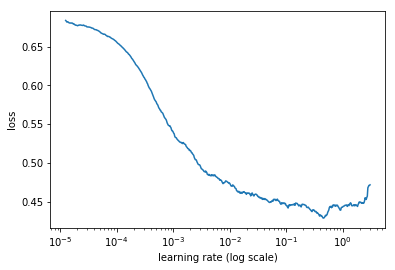

In [29]:
%matplotlib inline
learn.sched.plot()

In [35]:
lr = 0.01
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  4%|▎         | 22/625 [00:04<01:59,  5.05it/s, loss=0.419]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                               
    0      0.413875   0.428072  



[0.4280724]

In [38]:
preds = learn.predict_dl(md.test_dl)

In [46]:
# softmax
expsums = np.exp(preds).sum(axis=1)
probs = np.exp(preds) / expsums[:, None]

In [60]:
sub = pd.DataFrame({'id':test.id, 'click':probs[:, 1]})[['id', 'click']]

In [63]:
sub.to_csv('baseline_submission.csv')

In [62]:
from IPython.display import FileLink

In [64]:
FileLink('baseline_submission.csv')

/home/ubuntu/deeplearning/avazu/baseline_submission.csv